![](https://scikit-learn.org/stable/_images/grid_search_workflow.png)

In [810]:
import warnings
warnings.filterwarnings('ignore')

In [811]:
import numpy as np
import pandas as pd

import pickle

from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, matthews_corrcoef, precision_recall_curve, auc

from keras.utils import np_utils

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim import SGD

from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring
from skorch.callbacks import TensorBoard

In [812]:
# import configurations (file paths, etc.)
import yaml
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper
    
configFile = '../cluster/data/medinfmk/ddi/config/config.yml'

with open(configFile, 'r') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=Loader)

In [813]:
pathInput = cfg['filePaths']['dirRaw']
pathOutput = cfg['filePaths']['dirProcessed']
# path to store python binary files (pickles)
# in order not to recalculate them every time
pathPickles = cfg['filePaths']['dirProcessedFiles']['dirPickles']
pathRuns = cfg['filePaths']['dirProcessedFiles']['dirRuns']
pathPaperScores = cfg['filePaths']['dirRawFiles']['paper-individual-metrics-scores']
datasetDirs = cfg['filePaths']['dirRawDatasets']
DS1_path = str(datasetDirs[0])

# Helper Functions

In [814]:
def prepare_data(input_fea, input_lab, seperate=False):
    offside_sim_path = input_fea
    drug_interaction_matrix_path = input_lab
    drug_fea = np.loadtxt(offside_sim_path,dtype=float,delimiter=",")
    interaction = np.loadtxt(drug_interaction_matrix_path,dtype=int,delimiter=",")
    
    train = []
    label = []
    tmp_fea=[]
    drug_fea_tmp = []
            
    for i in range(0, (interaction.shape[0]-1)):
        for j in range((i+1), interaction.shape[1]):
            label.append(interaction[i,j])
            drug_fea_tmp_1 = list(drug_fea[i])
            drug_fea_tmp_2 = list(drug_fea[j])
            if seperate:
                 tmp_fea = (drug_fea_tmp_1,drug_fea_tmp_2)
            else:
                 tmp_fea = drug_fea_tmp_1 + drug_fea_tmp_2
            train.append(tmp_fea)

    return np.array(train), np.array(label)

In [815]:
def transfer_array_format(data):
    formated_matrix1 = []
    formated_matrix2 = []
    for val in data:
        formated_matrix1.append(val[0])
        formated_matrix2.append(val[1])
    return np.array(formated_matrix1), np.array(formated_matrix2)

In [816]:
def preprocess_labels(labels, encoder=None, categorical=True):
    if not encoder:
        encoder = LabelEncoder()
        encoder.fit(labels)
        y = encoder.transform(labels).astype(np.int32)
    if categorical:
        y = np_utils.to_categorical(y)
        print(y)
    return y, encoder

In [817]:
def preprocess_names(labels, encoder=None, categorical=True):
    if not encoder:
        encoder = LabelEncoder()
        encoder.fit(labels)
    if categorical:
        labels = np_utils.to_categorical(labels)
    return labels, encoder

In [818]:
def getStratifiedKFoldSplit(X,y,n_splits):
    skf = StratifiedKFold(n_splits=n_splits)
    return skf.split(X,y)
#     skf.get_n_splits(X, y)
#     for train_index, test_index in skf.split(X, y):
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]
#     return X_train, X_test, y_train, y_test

In [819]:
# x = np.arange(100)
# y = np.random.binomial(1,0.5,100)

# #print(x)
# #print(y)

# skf = StratifiedKFold(n_splits=5)
# s = skf.split(x,y)

# for i, indices in enumerate(s):
#     train = indices[0]
#     test = indices[1]
#     print(train)
#     print(test)
# #     print(indices)
#     print(i)
#     print("######################")

In [820]:
class NDD(nn.Module):
    def __init__(self, D_in=123, H1=300, H2=400, D_out=2, drop=0.5):
        super(NDD, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(D_in, H1) # Fully Connected
        self.fc2 = nn.Linear(H1, H2)
        self.fc3 = nn.Linear(H2, D_out)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)
        return x

In [821]:
def updateSimilarityDFSingleMetric(df, sim_type, metric, value):
    df.loc[df['Similarity'] == sim_type, metric ] = round(value,3)
    return df

In [822]:
def updateSimilarityDF(df, sim_type, AUROC, AUPR, F1, Rec, Prec):
    df = updateSimilarityDFSingleMetric(df, sim_type, 'AUC', AUROC)
    df = updateSimilarityDFSingleMetric(df, sim_type, 'AUPR', AUPR)
    df = updateSimilarityDFSingleMetric(df, sim_type, 'F-measure', F1)
    df = updateSimilarityDFSingleMetric(df, sim_type, 'Recall', Rec)
    df = updateSimilarityDFSingleMetric(df, sim_type, 'Precision', Prec)
    return df

In [823]:
def getNetParamsStr(net, str_hidden_layers_params, net_params_to_print=["max_epochs", "batch_size"]):
    net_params = [val for sublist in [[x,net.get_params()[x]] for x in net_params_to_print] for val in sublist]
    net_params_str = '-'.join(map(str, flattened))
    return(net_params_str+str_hidden_layers_params)

In [824]:
def writeReplicatedIndividualScoresCSV(net, df, destination, str_hidden_layers_params):
    filePath = destination + "replicatedIndividualScores_" + getNetParamsStr(net, str_hidden_layers_params) + ".csv"
    df.to_csv(path_or_buf = filePath, index=False)

In [825]:
def getNDDClassifier():
    net = NeuralNetClassifier(
        model,
        criterion=nn.CrossEntropyLoss,
        max_epochs=20,
        optimizer=SGD,
        optimizer__lr=0.01,
        optimizer__momentum=0.9,    
        optimizer__weight_decay=1e-6,    
        optimizer__nesterov=True,    
        batch_size=200,
        callbacks=callbacks,
        # Shuffle training data on each epoch
        iterator_train__shuffle=True,
        device=device,
    )
    return net

In [826]:
def avgMetrics(AUROC, AUPR, F1, Rec, Prec, kfold_nsplits):
    AUROC /= kfold_nsplits
    AUPR /= kfold_nsplits
    F1 /= kfold_nsplits
    Rec /= kfold_nsplits
    Prec /= kfold_nsplits
    return AUROC, AUPR, F1, Rec, Prec

# Run

In [827]:
df_paperIndividualScores = pd.read_csv(pathPaperScores)

df_replicatedIndividualScores = df_paperIndividualScores.copy()

for col in df_replicatedIndividualScores.columns:
    if col != 'Similarity':
        df_replicatedIndividualScores[col].values[:] = 0

In [828]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
soft = nn.Softmax(dim=1)

In [829]:
do_prepare_data = False
do_train_model = True
kfold_nsplits = 5
similaritiesToRun = df_paperIndividualScores['Similarity']
# similaritiesToRun = ["enzyme"]

for similarity in similaritiesToRun:
    input_fea = pathInput+DS1_path+"/" + similarity + "_Jacarrd_sim.csv"
    input_lab = pathInput+DS1_path+"/drug_drug_matrix.csv"
    dataPicklePath = pathPickles+"data_X_y_" + similarity + "_Jaccard.p"

    # Define model
    D_in, H1, H2, D_out, drop = X.shape[1], 400, 300, 2, 0.5
    str_hidden_layers_params = "-H1-" + str(H1) + "-H2-" + str(H2)
    model = NDD(D_in, H1, H2, D_out, drop)
    callbacks = []
    
    # Prepare data if not available
    if do_prepare_data:
        X,y = prepare_data(input_fea, input_lab, seperate = False)

        with open(dataPicklePath, 'wb') as f:
            pickle.dump([X, y], f)

    # Load X,y and split in to train, test
    with open(dataPicklePath, 'rb') as f:
        X, y = pickle.load(f)
    
    X = X.astype(np.float32)
    y = y.astype(np.int64)    
    
    AUROC, AUPR, F1, Rec, Prec = 0,0,0,0,0
    kFoldSplit = getStratifiedKFoldSplit(X,y,n_splits=kfold_nsplits)
    for i, indices in enumerate(kFoldSplit):
        train_index = indices[0]
        test_index = indices[1]
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        # Create Network Classifier
        net = getNDDClassifier()
        
        # Fit and save OR load model
        modelPicklePath = pathPickles+"model_params/model_params_fold" + str(i) + "_" + str_hidden_layers_params+ "_" + similarity + ".p"
        if do_train_model:
            net.fit(X_train, y_train)
            net.save_params(f_params=modelPicklePath)
        else:
            net.initialize()  # This is important!
            net.load_params(f_params=modelPicklePath)

        # Make predictions
        y_pred = net.predict(X_test)
        lr_probs = soft(net.forward(X_test))[:,1]
        lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)

        AUROC += roc_auc_score(y_test, y_pred)
        AUPR += auc(lr_recall, lr_precision)
        F1 += f1_score(y_test, y_pred)
        Rec += recall_score(y_test, y_pred)
        Prec += precision_score(y_test, y_pred)
        
        print(i, similarity, AUROC, AUPR, F1, Rec, Prec)
        
    
    AUROC, AUPR, F1, Rec, Prec = avgMetrics(AUROC, AUPR, F1, Rec, Prec, kfold_nsplits)
    print(similarity, AUROC, AUPR, F1, Rec, Prec)
    
    # Fill replicated metrics
    updateSimilarityDF(df_replicatedIndividualScores, similarity, AUROC, AUPR, F1, Rec, Prec)
    
# Write CSV
writeReplicatedIndividualScoresCSV(net, df_replicatedIndividualScores, pathRuns, str_hidden_layers_params)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6264       0.6758        0.6258  1.9311
      2        0.6171       0.6758        0.6226  1.9490
      3        0.6103       0.6758        0.6514  1.7302
      4        0.6050       0.6758        0.6253  1.8612
      5        0.6053       0.6758        0.6260  1.9754
      6        0.6061       0.6758        0.6154  1.9608
      7        0.6030       0.6757        0.6267  1.9462
      8        0.6063       0.6758        0.6342  1.9354
      9        0.6029       0.6758        0.6302  1.9364
     10        0.6039       0.6762        0.6189  1.9230
     11        0.6061       0.6755        0.6390  1.9202
     12        0.6024       0.6761        0.6331  1.9181
     13        0.6025       0.6758        0.6311  1.9044
     14        0.6031       0.6766        0.6247  1.9200
     15        0.5993       0.6715        0.6303  1.8904
     16        0.6001       0.6

      9        0.3671       0.7259        0.6831  2.1066
     10        0.3620       0.7226        0.6636  1.9562
     11        0.3584       0.7247        0.7153  1.9796
     12        0.3554       0.7239        0.6994  1.9612
     13        0.3493       0.7234        0.7160  1.9435
     14        0.3457       0.7222        0.7878  1.9495
     15        0.3423       0.7277        0.7111  1.9528
     16        0.3395       0.7231        0.7155  1.9537
     17        0.3373       0.7243        0.7194  1.9474
     18        0.3346       0.7244        0.7626  1.9957
     19        0.3318       0.7207        0.7284  2.2627
     20        0.3295       0.7286        0.7410  1.9731
0 target 0.6321751182635624 0.5825907140925904 0.454974358974359 0.3423896264279098 0.6778728606356969
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3375       0.7423        0.6494  1.9436
      2        0.3319       0.7508        

     12        0.5068       0.7040        0.6102  1.9916
     13        0.5042       0.7037        0.6014  1.9493
     14        0.5025       0.7073        0.5907  1.9475
     15        0.5014       0.7036        0.6435  1.9280
     16        0.5011       0.7062        0.5945  1.9662
     17        0.5001       0.7057        0.6060  1.8562
     18        0.4980       0.7062        0.6120  1.9627
     19        0.4982       0.7066        0.6062  1.9322
     20        0.4967       0.7156        0.5863  1.9169
0 transporter 0.604867003182513 0.5284542578381921 0.39782362916902203 0.2896984666049192 0.6347237880496054
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4984       0.7088        0.6169  2.1633
      2        0.4964       0.7006        0.6235  2.1607
      3        0.4931       0.7143        0.6157  1.9774
      4        0.4932       0.7066        0.6123  1.9500
      5        0.4932       0.6962  

     15        0.4344       0.6873        0.6205  2.0295
     16        0.4314       0.7136        0.6098  2.0667
     17        0.4300       0.6909        0.6374  2.3387
     18        0.4276       0.7127        0.6122  1.9974
     19        0.4264       0.6961        0.6166  2.5295
     20        0.4253       0.6985        0.5985  2.4709
0 enzyme 0.6190775352973376 0.5889849259751829 0.4264428121720882 0.31367706082124114 0.6657929226736566
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4277       0.7210        0.5865  2.4114
      2        0.4260       0.7169        0.5862  2.3603
      3        0.4239       0.7219        0.5938  2.4785
      4        0.4227       0.7363        0.5797  2.4253
      5        0.4209       0.7235        0.5882  2.3830
      6        0.4207       0.7139        0.6052  1.9438
      7        0.4182       0.7226        0.5930  1.9795
      8        0.4177       0.7207      

     19        0.3821       0.7298        0.6348  1.8930
     20        0.3799       0.7257        0.6353  1.8213
0 pathway 0.6310810356302675 0.5974075914435812 0.4514884233737596 0.3371410929299166 0.6832116788321168
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3837       0.7161        0.5985  1.8151
      2        0.3781       0.7300        0.5892  1.8137
      3        0.3765       0.7281        0.6098  2.0036
      4        0.3738       0.7244        0.6009  1.9845
      5        0.3712       0.7298        0.5986  1.9893
      6        0.3710       0.7265        0.6216  2.1948
      7        0.3687       0.7257        0.6215  1.9602
      8        0.3664       0.7333        0.6058  1.9499
      9        0.3667       0.7315        0.6018  1.9440
     10        0.3632       0.7317        0.6152  1.9538
     11        0.3627       0.7151        0.6423  2.0355
     12        0.3610       0.7425      

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.2598       0.7455        0.6612  1.7486
      2        0.2516       0.7544        0.6396  1.7811
      3        0.2464       0.7533        0.6386  1.7823
      4        0.2437       0.7541        0.6290  1.7403
      5        0.2423       0.7553        0.6288  1.7978
      6        0.2393       0.7543        0.6295  1.7591
      7        0.2351       0.7573        0.6375  1.7378
      8        0.2332       0.7596        0.6187  1.7545
      9        0.2310       0.7597        0.6311  1.8734
     10        0.2275       0.7635        0.6284  1.7605
     11        0.2264       0.7644        0.6132  1.7635
     12        0.2255       0.7582        0.6423  1.7717
     13        0.2227       0.7623        0.6452  1.7801
     14        0.2191       0.7597        0.6330  1.8238
     15        0.2202       0.7644        0.6444  1.7919
     16        0.2168       0.7

      2        0.5227       0.6777        0.7452  2.3916
      3        0.5120       0.7157        0.5630  2.3480
      4        0.5158       0.6953        0.5837  1.9979
      5        0.5226       0.6975        0.5857  2.0067
      6        0.5271       0.6762        0.6361  1.9625
      7        0.5180       0.7138        0.5619  2.0029
      8        0.5067       0.6766        0.6831  1.9727
      9        0.5007       0.7188        0.5634  2.0476
     10        0.5093       0.6875        0.6270  1.9644
     11        0.5252       0.6842        0.6061  1.9711
     12        0.5351       0.7048        0.5850  1.9322
     13        0.5204       0.7001        0.5868  1.9061
     14        0.5167       0.6851        0.6072  1.9837
     15        0.5216       0.7062        0.5808  2.0573
     16        0.5232       0.7105        0.5668  1.9783
     17        0.5168       0.6956        0.5971  2.3828
     18        0.5297       0.6982        0.5896  2.4299
     19        0.5213       0.6

     15        0.4781       0.7252        0.5289  1.7613
     16        0.4677       0.7349        0.5213  1.7573
     17        0.4731       0.7583        0.5048  1.8166
     18        0.4853       0.7604        0.4955  1.8098
     19        0.4789       0.7616        0.4985  1.7639
     20        0.4838       0.7552        0.5007  1.7664
1 offsideeffect 1.376255295711216 1.3196404247148268 1.1343416204412782 1.0401358443964186 1.315597909851331
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4868       0.7496        0.5067  1.8134
      2        0.4869       0.7514        0.5015  1.7575
      3        0.4876       0.7573        0.5046  1.7535
      4        0.4782       0.7534        0.5020  1.7525
      5        0.4735       0.7651        0.4935  1.7669
      6        0.4684       0.7652        0.4903  1.7635
      7        0.4658       0.7384        0.5166  1.9508
      8        0.4586       0.7531  

# Compare to Paper

In [830]:
print(df_paperIndividualScores)

      Similarity    AUC   AUPR  F-measure  Recall  Precision
0           chem  0.631  0.455      0.527   0.899      0.373
1         target  0.787  0.642      0.617   0.721      0.540
2    transporter  0.682  0.568      0.519   0.945      0.358
3         enzyme  0.734  0.599      0.552   0.579      0.529
4        pathway  0.767  0.623      0.587   0.650      0.536
5     indication  0.802  0.654      0.632   0.740      0.551
6     sideeffect  0.778  0.601      0.619   0.748      0.528
7  offsideeffect  0.782  0.606      0.617   0.764      0.517


In [831]:
print(df_replicatedIndividualScores)

      Similarity    AUC   AUPR  F-measure  Recall  Precision
0           chem  0.501  0.379      0.018   0.009      0.625
1         target  0.731  0.720      0.621   0.572      0.707
2    transporter  0.639  0.563      0.480   0.409      0.614
3         enzyme  0.671  0.630      0.535   0.487      0.643
4        pathway  0.706  0.691      0.587   0.560      0.660
5     indication  0.781  0.788      0.692   0.672      0.740
6     sideeffect  0.556  0.549      0.218   0.253      0.555
7  offsideeffect  0.661  0.678      0.469   0.443      0.699


In [832]:
diff_metrics = ['AUC', 'AUPR', 'F-measure', 'Recall', 'Precision']
df_diff = df_paperIndividualScores[diff_metrics] - df_replicatedIndividualScores[diff_metrics]
df_diff_abs = df_diff.abs()
df_diff_percent = (df_diff_abs / df_paperIndividualScores[diff_metrics]) * 100

In [833]:
df_diff

,AUC,AUPR,F-measure,Recall,Precision
0,0.130,0.076,5.090000e-01,0.890,-0.252
1,0.056,-0.078,-4.000000e-03,0.149,-0.167
2,0.043,0.005,3.900000e-02,0.536,-0.256
3,0.063,-0.031,1.700000e-02,0.092,-0.114
4,0.061,-0.068,1.110223e-16,0.090,-0.124
5,0.021,-0.134,-6.000000e-02,0.068,-0.189
6,0.222,0.052,4.010000e-01,0.495,-0.027
7,0.121,-0.072,1.480000e-01,0.321,-0.182


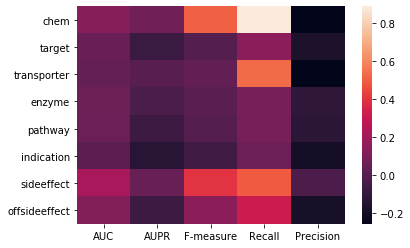

In [834]:
from seaborn import heatmap
heatmap(df_diff, yticklabels=df_paperIndividualScores["Similarity"])

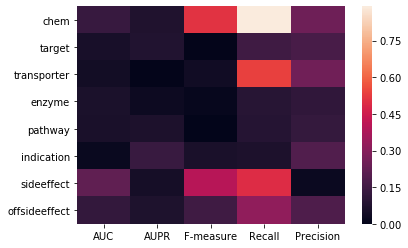

In [835]:
heatmap(df_diff_abs, yticklabels=df_paperIndividualScores["Similarity"])

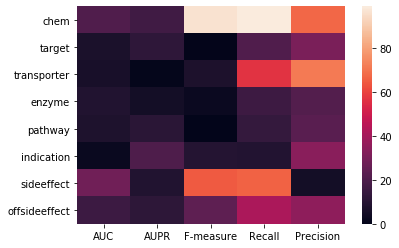

In [836]:
heatmap(df_diff_percent, yticklabels=df_paperIndividualScores["Similarity"])

In [837]:
from sklearn.metrics import mean_squared_error
mean_squared_error(df_paperIndividualScores[diff_metrics],
                   df_replicatedIndividualScores[diff_metrics])

0.057754824999999996